In [1047]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation
import time

from itertools import count
from IPython import display

import seaborn as sns
from IPython.display import HTML
from scipy.io import loadmat
from utils.helper_util import Func_GaussElimination,plotter

In [1048]:
##diffusivity
alpha  = 0.005 ;



## Delta t
dt = 0.02 ;


## grid
Nx=19
Ny=19
xtotal  = np.linspace(0,1,Nx+2)
x=xtotal[1:Nx+1]
ytotal  = np.linspace(0,1,Ny+2)
y=ytotal[1:Ny+1]
dx = x[1] - x[0] 
dy=y[1] - y[0] 
xv, yv = np.meshgrid(x, y, indexing='ij')

X,Y=np.meshgrid(xtotal, ytotal, indexing='ij')

kappa=0.02*np.exp(-((((xv-0.7)**2)/0.09)+(((yv-0.6)**2)/0.25)))
b=kappa/(alpha)
Q=np.zeros((Nx*Ny,1))
b_vector=np.zeros((Nx*Ny,1))

BCB=(-0.3/dx)*np.ones(Nx)
BCL=0.5-0.5*np.cos(2*np.pi*y)
BCT=0.5+0.5*np.sin(4*np.pi*x-0.5*np.pi)
BCR=np.zeros(Ny)


In [1049]:
def pointer_vector(Nx, Ny):
    iQ=np.nan*np.zeros((Nx,Ny))
    ids=np.arange(start=0,stop=(Nx)*(Ny))
    k=0
    for i in range(Nx):
        for j in range(Ny):
            iQ[i,j]=int(ids[k])
            k=k+1
            if k==len(ids):
                break
        if k==len(ids):
            break
            
    return iQ.astype(int)

In [1050]:
def LaplaceOpt_Aq(Q,Nx,Ny):

    iQ=pointer_vector(Nx, Ny)

    ## Initialize output 
    Y=np.nan*np.ones((len(Q),1))

    ## inner domain
    for i in range(1,Ny-1):
        for j in range(1,Nx-1):
            Y[iQ[i, j]] = (((Q[iQ[i-1, j]] - 2*Q[iQ[i, j]] + Q[iQ[i+1, j]] ) /(dx**2))+ ((Q[iQ[i, j-1]] - 2*Q[iQ[i, j]] + Q[iQ[i, j+1]] ) /(dy**2))) +b[i,j] 

    ## Edges
    # left (Dirichlet)
    i = 0 ;
    for j in range(1,Ny-1):
            Y[iQ[i, j]] = (( (-2*Q[iQ[i, j]] + Q[iQ[i+1, j]] ) /(dx**2))+ ((Q[iQ[i, j-1]] - 2*Q[iQ[i, j]] + Q[iQ[i, j+1]] ) /(dy**2))) +b[i,j]

    # top (Dirichlet)
    j = -1
    for i in range(1,Nx-1):
            Y[iQ[i, j]] = (((Q[iQ[i-1, j]] - 2*Q[iQ[i, j]] + Q[iQ[i+1, j]] ) /(dx**2))+ ((Q[iQ[i, j-1]] - 2*Q[iQ[i, j]] ) /(dy**2))) +b[i,j]


    # Bottom (Neuman)
    j = 0
    for i in range(1,Nx-1):
            Y[iQ[i, j]] = (((Q[iQ[i-1, j]] - 2*Q[iQ[i, j]] + Q[iQ[i+1, j]] ) /(dx**2))+ ((-1*Q[iQ[i, j]] + Q[iQ[i, j+1]] ) /(dy**2))) +b[i,j] 


    # Right (Neuman)
    i=-1
    for j in range(1,Ny-1):
        Y[iQ[i, j]] = (( (Q[iQ[i-1, j]] - Q[iQ[i, j]] ) /(dx**2))+ ((Q[iQ[i, j-1]] - 2*Q[iQ[i, j]] + Q[iQ[i, j+1]] ) /(dy**2))) +b[i,j] 

        
    ## Corners
    # bottom left
    i = 0
    j = 0
    Y[iQ[i, j]] = (( (-2*Q[iQ[i, j]] + Q[iQ[i+1, j]] ) /(dx**2))+ ((-1*Q[iQ[i, j]] + Q[iQ[i, j+1]] ) /(dy**2))) +b[i,j] 

    ## bottom right
    i=-1
    j=0

    Y[iQ[i, j]] = (((Q[iQ[i-1, j]] - Q[iQ[i, j]] ) /(dx**2))+ ((-Q[iQ[i, j]] + Q[iQ[i, j+1]] ) /(dy**2))) +b[i,j] 

    ## top left
    j=-1
    i=0
    Y[iQ[i, j]] = (( (-2*Q[iQ[i, j]] + Q[iQ[i+1, j]] ) /(dx**2))+ ((Q[iQ[i, j-1]] - 2*Q[iQ[i, j]] ) /(dy**2))) +b[i,j] 

    ## top right
    i=-1
    j=-1
    Y[iQ[i, j]] = (((Q[iQ[i-1, j]] - Q[iQ[i, j]] ) /(dx**2))+ (( Q[iQ[i, j-1]] - 2*Q[iQ[i, j]] )/(dy**2))) +b[i,j] 
    return Y
              

In [1051]:
def uBC_Laplace(Nx,Ny,dx,dy,BCB,BCL,BCT,BCR):
    iQ=pointer_vector(Nx, Ny)

    uBC  = np.zeros((Nx*Ny, 1)) ;

    ## Edges
    #left (Dirichlet)
    i = 0
    for j in range(1,Ny-1):
        uBC[iQ[i, j]] = BCL[j] / (dx**2)

    #bottom (Neuman)
    j = 0
    for i in range(1,Nx-1):
        uBC[iQ[i, j]] = -BCB[i] / (dy)

    # right(Neuman)
    i = -1
    for j in range(1,Ny-1):
        uBC[iQ[i, j]] = BCR[j] / (dy)

    # top(Dirichlet)
    j = -1
    for i in range(1,Nx-1):
        uBC[iQ[i, j]] = BCT[i] / (dx**2)

    ## Corners
    # bottom left (D-N)
    i = 0 ;
    j = 0 ;
    uBC[iQ[i, j]] = (BCL[i] /(dx**2)) - (BCB[j] /(dy))

    # bottom right (N-N)
    i = -1
    j = 0 
    uBC[iQ[i, j]] = (BCR[i] /(dx)) - (BCB[j] /(dy))

    # top left (D-D)
    i = 0
    j = -1 
    uBC[iQ[i, j]] = (BCL[i] /(dx**2)) + (BCT[j] /(dy**2))

    # top right (N-D)
    i=-1
    j=-1
    uBC[iQ[i, j]] = (BCR[i] /(dx)) + (BCT[j] /(dy**2))
    return uBC

In [1052]:
d_old=b_vector-LaplaceOpt_Aq(Q,Nx,Ny)-uBC_Laplace(Nx,Ny,dx,dy,BCB,BCL,BCT,BCR)
r_old=b_vector-LaplaceOpt_Aq(Q,Nx,Ny)-uBC_Laplace(Nx,Ny,dx,dy,BCB,BCL,BCT,BCR)


for i in range(100):
    alpha_factor=((r_old.T)@r_old)/((d_old.T)@(LaplaceOpt_Aq(d_old,Nx,Ny)+uBC_Laplace(Nx,Ny,dx,dy,BCB,BCL,BCT,BCR)))

    Q=Q+(alpha_factor[0,0])*d_old
    r_new=r_old-(alpha_factor[0,0])*(LaplaceOpt_Aq(d_old,Nx,Ny)+uBC_Laplace(Nx,Ny,dx,dy,BCB,BCL,BCT,BCR))

    beta=((r_new.T)@(r_new))/((r_old.T)@(r_old))
    d_new=r_new+(beta[0,0])*d_old

    d_old=d_new
    r_old=r_new
    
Solution_Matrix=np.zeros((Nx,Ny))
k=0
for i in range(Nx):
    for j in range(Ny):
        Solution_Matrix[i,j]=Q[k]
        k=k+1

In [1053]:
BCBt=(Solution_Matrix[:,0]-dx*(-0.3))
BCLt=0.5-0.5*np.cos(2*np.pi*ytotal)
BCTt=0.5+0.5*np.sin((4*np.pi*xtotal)-(0.5*np.pi))
BCRt=Solution_Matrix[-1,:]

In [1054]:
Final_matrix=np.zeros((Nx+2,Nx+2))
Final_matrix[0,:]=BCLt
Final_matrix[-1,1:Nx+1]=BCRt
Final_matrix[1:Ny+1,0]=BCBt
Final_matrix[:,-1]=BCTt

for i in range(1,Nx+1):
    for j in range(1,Ny+1):
        Final_matrix[i,j]=Solution_Matrix[i-1,j-1]

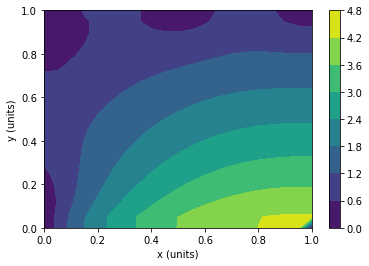

In [1055]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Final_matrix)
fig.colorbar(cp)
#ax.set_title('Filled Contours Plot')
ax.set_xlabel('x (units)')
ax.set_ylabel('y (units)')
plt.show()

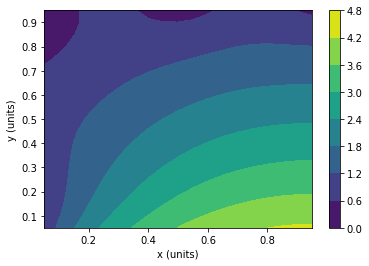

In [1028]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(xv, yv, Solution_Matrix)
fig.colorbar(cp)
#ax.set_title('Filled Contours Plot')
ax.set_xlabel('x (units)')
ax.set_ylabel('y (units)')
plt.show()

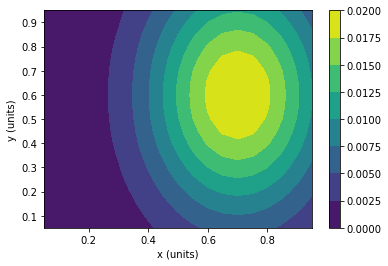

In [1040]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(xv, yv, kappa/(1))
fig.colorbar(cp)
#ax.set_title('Filled Contours Plot')
ax.set_xlabel('x (units)')
ax.set_ylabel('y (units)')
plt.show()

In [1033]:
Solution_Matrix.shape

(19, 19)

In [1034]:
b.shape

(19, 19)